<a href="https://colab.research.google.com/github/sharanbalu/Task5/blob/main/User_aggrigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-1-bb6607897f90>:26: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  user_engagement_df['week'] = user_engagement_df['time_stamp'].dt.week
<ipython-input-1-bb6607897f90>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_df['adopted'] = user_df['object_id'].apply(lambda x: user_engagement_df[user_engagement_df['user_id']==x]['adopted'].max())


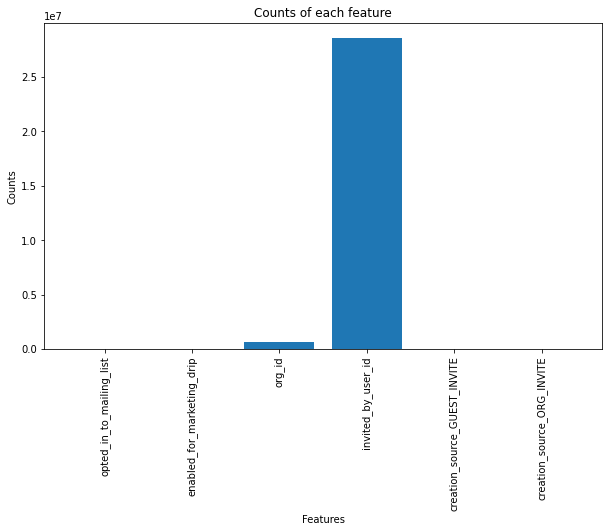

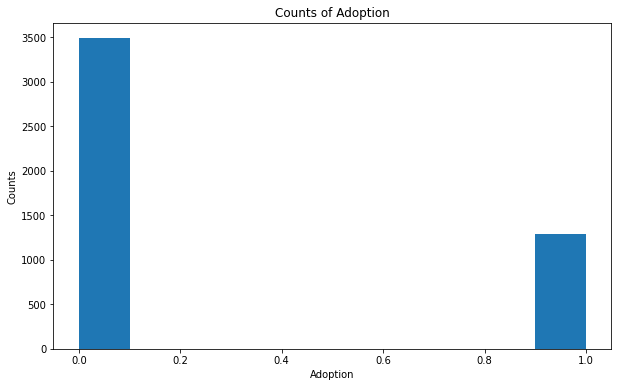

Accuracy: 0.6997907949790795
Confusion Matrix: [[669   0]
 [287   0]]


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Load data
users_df = pd.read_csv("/content/takehome_users.csv", encoding='latin-1')
user_engagement_df = pd.read_csv("/content/takehome_user_engagement.csv")

# Data Cleaning
users_df.drop_duplicates(subset='object_id', keep="first", inplace=True)
users_df.dropna(inplace=True)
user_engagement_df['time_stamp'] = pd.to_datetime(user_engagement_df['time_stamp'])
user_engagement_df.drop_duplicates(subset=['user_id', 'time_stamp'], inplace=True)

# Feature Engineering
user_engagement_df.sort_values(by=['user_id', 'time_stamp'], inplace=True)
user_engagement_df['prev_time_stamp'] = user_engagement_df.groupby('user_id')['time_stamp'].shift()
user_engagement_df['time_diff'] = (user_engagement_df['time_stamp'] - user_engagement_df['prev_time_stamp']).dt.days.fillna(0)

# Data Aggregation
user_engagement_df['week'] = user_engagement_df['time_stamp'].dt.week
user_engagement_df['year'] = user_engagement_df['time_stamp'].dt.year
user_engagement_df = user_engagement_df.groupby(['user_id', 'year', 'week']).agg({'visited': 'sum'}).reset_index()

# Target Variable Creation
user_engagement_df['adopted'] = user_engagement_df.groupby('user_id')['visited'].rolling(window=3, min_periods=1).apply(lambda x: np.sum(x) >= 3).reset_index(0, drop=True).astype(int)
user_df = users_df[['object_id', 'creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id']]
user_df['adopted'] = user_df['object_id'].apply(lambda x: user_engagement_df[user_engagement_df['user_id']==x]['adopted'].max())

# Feature Selection
X = user_df[['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id']]
X = pd.get_dummies(X, columns=['creation_source'])
y = user_df['adopted']

# Exploratory Data Analysis
plt.figure(figsize=(10,6))
plt.bar(X.columns, X.sum())
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Counts')
plt.title('Counts of each feature')
plt.show()

plt.figure(figsize=(10,6))
plt.hist(y)
plt.xlabel('Adoption')
plt.ylabel('Counts')
plt.title('Counts of Adoption')
plt.show()

# Modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Model Evaluation
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Confusion Matrix:', confusion_matrix(y_test, y_pred))
